In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import wandb
import Neural_Lib_Flo as nlb
import wandb_library as wl 
import training_lib as tl
import torch.nn.functional as F

In [3]:
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set the root directory
root_dir_sensorium = '/project/data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data'
images_path = '/project/subiculum/data/images_uint8.npy'
v1_responses_path = '/project/subiculum/data/V1_Data.mat'
sub_responses_path= '/project/subiculum/data/Post_Sub_Data.mat'

I have already run a sweep using wandb, so this won't be done again here.

In [4]:
api = wandb.Api()
run = api.run("seifertflo/V1 Training 17-06-2024/2mr3hewa")
config=run.config
v1_model=nlb.configure_model(config, 13, device)
v1_train_loader, v1_val_loader, v1_test_loader = nlb.dataloader_from_mat(images_path, v1_responses_path, 75, 125, 64)
tl.training_and_eval_with_lr(v1_model, config.get("epochs"), v1_train_loader, v1_test_loader, v1_val_loader, device, save_model=True, path_for_saving='models/v1_model.pt')

/usr/local/lib/python3.8/dist-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


Epoch [1/50], validation correlation: -0.0021, trainloss: 0.2568
Epoch [2/50], validation correlation: 0.0272, trainloss: 0.3488
Epoch [3/50], validation correlation: 0.0501, trainloss: 0.2273
Epoch [4/50], validation correlation: 0.0372, trainloss: 0.3589
Epoch [5/50], validation correlation: 0.0682, trainloss: 0.4550
Epoch [6/50], validation correlation: 0.0858, trainloss: 0.3269
Epoch [7/50], validation correlation: 0.0840, trainloss: 0.2232
Epoch [8/50], validation correlation: 0.0519, trainloss: 0.2302
Epoch [9/50], validation correlation: 0.0755, trainloss: 0.2685
Epoch [10/50], validation correlation: 0.1000, trainloss: 0.2317
Epoch [11/50], validation correlation: 0.0616, trainloss: 0.3419
Epoch [12/50], validation correlation: 0.1049, trainloss: 0.3682
Epoch [13/50], validation correlation: 0.0968, trainloss: 0.2636
Epoch [14/50], validation correlation: 0.1331, trainloss: 0.3121
Epoch [15/50], validation correlation: 0.0890, trainloss: 0.3236
Epoch [16/50], validation correla

We can now use the same configuration to get a rough idea of what training with the Sub Data would give:

In [5]:
sub_train_loader, sub_val_loader, sub_test_loader =nlb.dataloader_from_mat(images_path, sub_responses_path, 75, 125, 64)
sub_model=nlb.configure_model(config, 37, device)
tl.training_and_eval_with_lr(sub_model, config.get("epochs"),sub_train_loader, sub_val_loader, sub_test_loader, device, save_model=True, path_for_saving='models/sub_model.pt'), 

Epoch [1/50], validation correlation: 0.0425, trainloss: 0.4294
Epoch [2/50], validation correlation: 0.0531, trainloss: 0.3964
Epoch [3/50], validation correlation: 0.0536, trainloss: 0.4509
Epoch [4/50], validation correlation: 0.0623, trainloss: 0.3821
Epoch [5/50], validation correlation: 0.0566, trainloss: 0.5785
Epoch [6/50], validation correlation: 0.0580, trainloss: 0.3783
Epoch [7/50], validation correlation: 0.0398, trainloss: 0.3746
Epoch     8: reducing learning rate of group 0 to 1.0000e-02.
Epoch [8/50], validation correlation: 0.0554, trainloss: 0.4526
Epoch [9/50], validation correlation: 0.0584, trainloss: 0.3304
Early stopping triggered!
model saved asmodels/sub_model.pt
Test Loss: 0.4759
Test Correlation: 0.0535


(None,)

As one gets a correlation of ~30% for the Sensorium data, it would be helpful to understand why this is not reached for the v1 data here. 

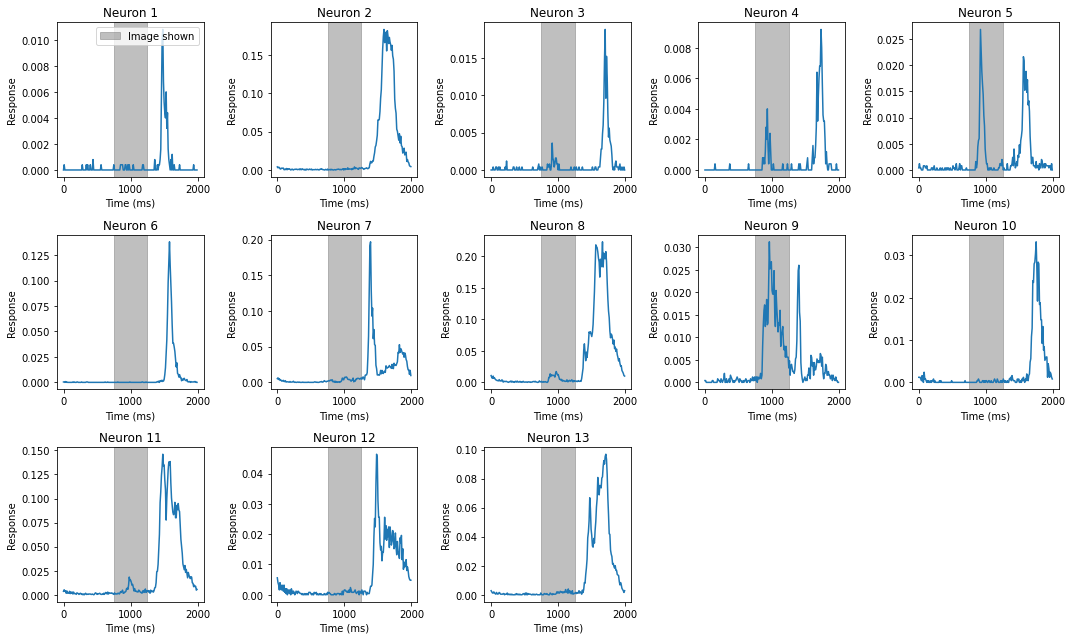

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
def plot_avrg_response(images_path, response_path):
    # Load Images to np.array
    images = np.load(images_path)

    # Load responses and preprocess them
    responses, _, _ = nlb.load_mat_file(response_path)
    responses = np.transpose(responses, (1, 2, 0))

    # Look at mean data for neurons
    responses_mean = np.mean(responses, axis=0, keepdims=True)

    # Define the number of plots
    num_plots = responses.shape[2]
    neuron_indices = range(num_plots)

    # Create a 3x5 grid of subplots
    fig, axs = plt.subplots(int(np.ceil(float(num_plots)/5.0)),5, figsize=(15, 9))
    axs = axs.flatten()  # Flatten the 2D array to 1D for easier iteration

    # Create a custom legend patch
    legend_patch = mpatches.Patch(color='gray', alpha=0.5, label='Image shown')

    # Plot each neuron data
    x = np.arange(0, 2000, 10)
    for i, neuron_index in enumerate(neuron_indices):
        if i < len(neuron_indices):  # Ensure we don't go out of bounds
            neuron_mean = responses_mean[:, :, neuron_index]
            axs[i].plot(x, neuron_mean[0, :])
            axs[i].axvspan(750, 1250, color='gray', alpha=0.5)  # Add transparent gray tile
            axs[i].set_title(f'Neuron {neuron_index + 1}')
            axs[i].set_xlabel('Time (ms)')
            axs[i].set_ylabel('Response')
            # Add the legend to the first plot only to avoid repetition
            if i == 0:
                axs[i].legend(handles=[legend_patch])

    # Remove empty subplots (if any)
    for j in range(len(neuron_indices), len(axs)):
        fig.delaxes(axs[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()
plot_avrg_response(images_path, v1_responses_path)

The same can be done for the sub data

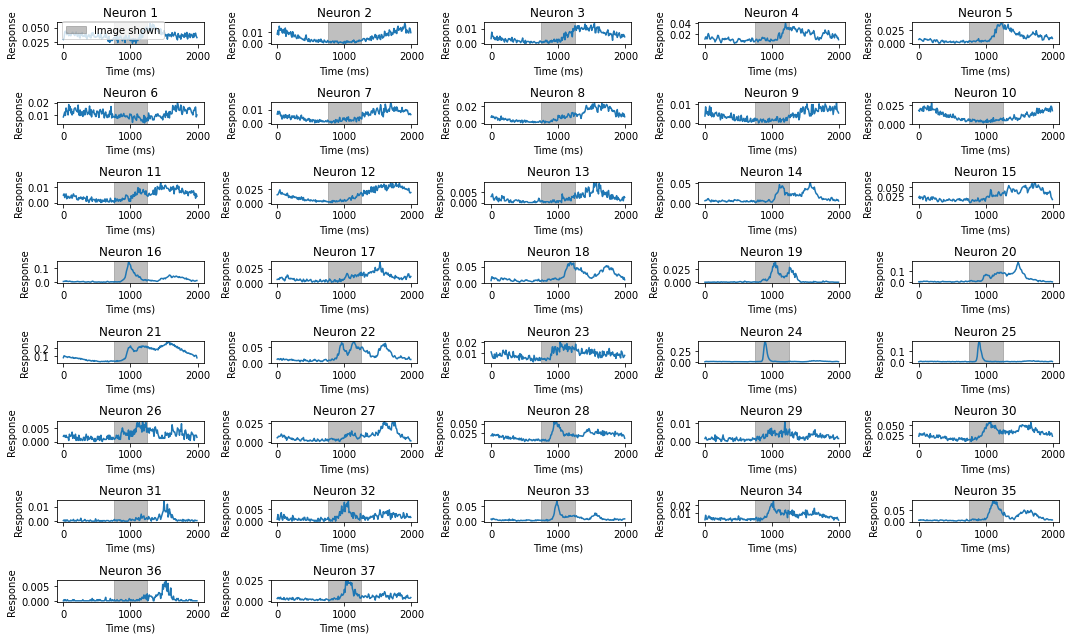

In [7]:
plot_avrg_response(images_path, sub_responses_path)

This shows the structure of the responses.
Now Ill compute oracle of the sensorium Data to compare the best neurons to the neurons here.

In [8]:
sensorium_train_loader, sensorium_val_loader, sensorium_test_loader = nlb.dataloader_from_npy_pretraining(root_dir_sensorium, device)
sensorium_model = nlb.ConvModel(layers=5, input_kern=11, hidden_kern=5, hidden_channels=32, output_dim=8372).to(device)
#tl.train_and_eval(sensorium_model, 100, sensorium_train_loader, sensorium_test_loader, sensorium_val_loader, device,gamma=1e-2,lr=1e-3, save_model=True, path_for_saving=("models/sens_model.pt"))

In [9]:
state_dict_sens = torch.load('models/sens_model.pt')
sensorium_model.load_state_dict(state_dict_sens)
sensorium_model.to(device)

ConvModel(
  (conv_layers): Sequential()
  (core): Sequential(
    (0): Conv2d(1, 32, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU()
    (6): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU()
    (9): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): SiLU()
    (12): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): SiLU()
  )
  (readout): GaussianReadou

In [10]:
with torch.no_grad():
    sens_val_corrs = nlb.get_correlations(sensorium_model, sensorium_val_loader, device)
best_neurons = np.argsort(-sens_val_corrs)

Now we will compute the spike triggered average (which can be seen as a first approximation of a MEI)
1. Do it by averaging over the images: implement a function for this. Advantage: Does not rely on the trained model.
2. Use the model: Here we can use random inputs to generate STAs.
3. Use the model: Compute Gradient RFs
4. Generate MEIs.

Shows the STA for the best neurons (in terms of correlation on the validation loader):
torch.Size([5994])
Processing neuron 1732...
Processing neuron 1503...
Processing neuron 7019...
Processing neuron 2574...
Processing neuron 3136...
Processing neuron 4464...
Processing neuron 746...
Processing neuron 4960...
Processing neuron 4670...
Processing neuron 1776...


/project/subiculum/code/Neural_Lib_Flo.py:884: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


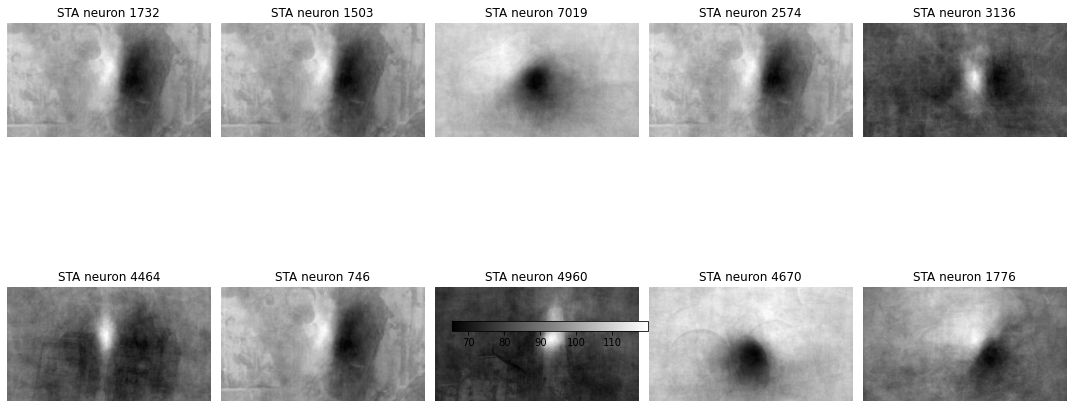

In [11]:
nlb.sta_wo_model(device,best_neurons, root_dir_sensorium)


/project/subiculum/code/Neural_Lib_Flo.py:841: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_tensor = torch.tensor(batch, dtype=torch.float32).to(device)


torch.Size([2500, 64, 64])
torch.Size([13, 2500])


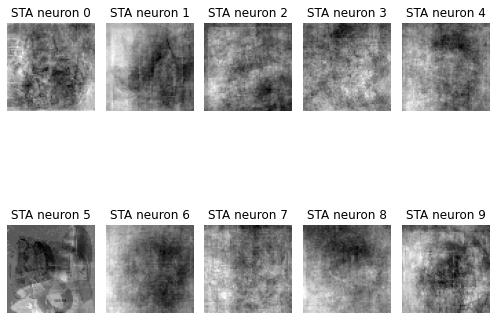

In [12]:
neurons=[0,1,2,3,4,5,6,7,8,9,10,11,12]
nlb.sta_wo_model(device, neurons ,v1_responses_path, images_path,data_is_npy=False)

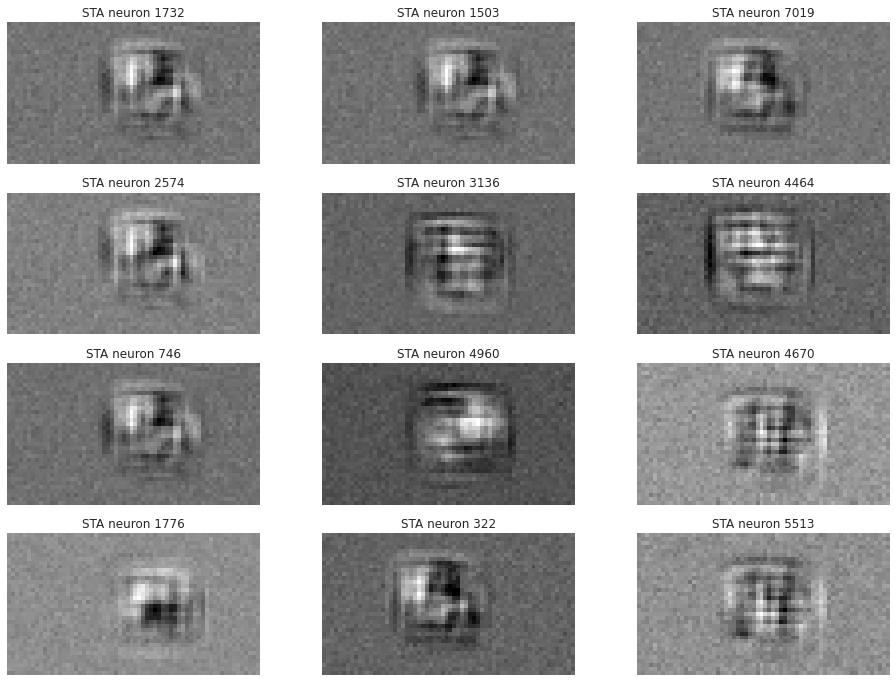

In [13]:
nlb.STA_model_sens(sensorium_model, 'models/sens_model.pt', best_neurons)


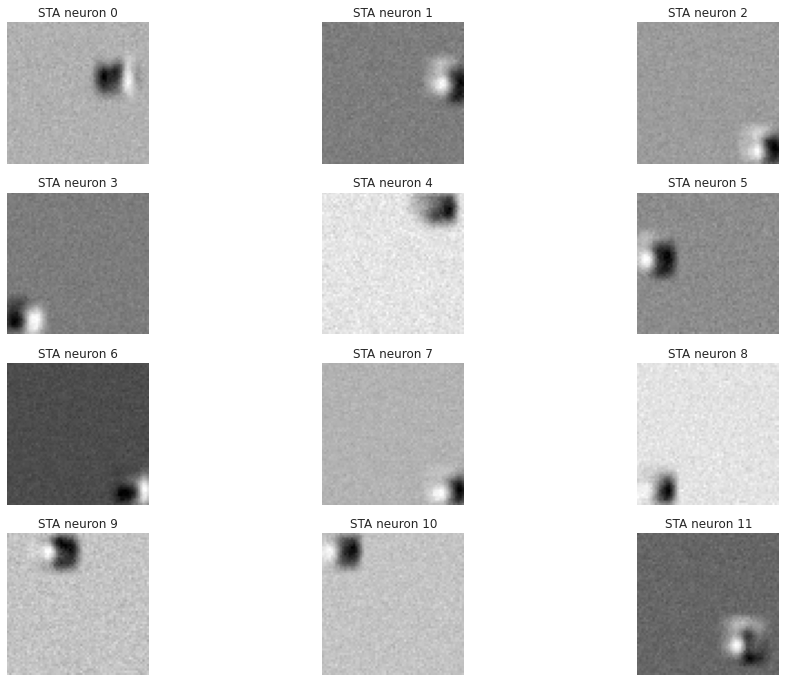

In [14]:
nlb.STA_model(v1_model, 'models/v1_model.pt', neurons)

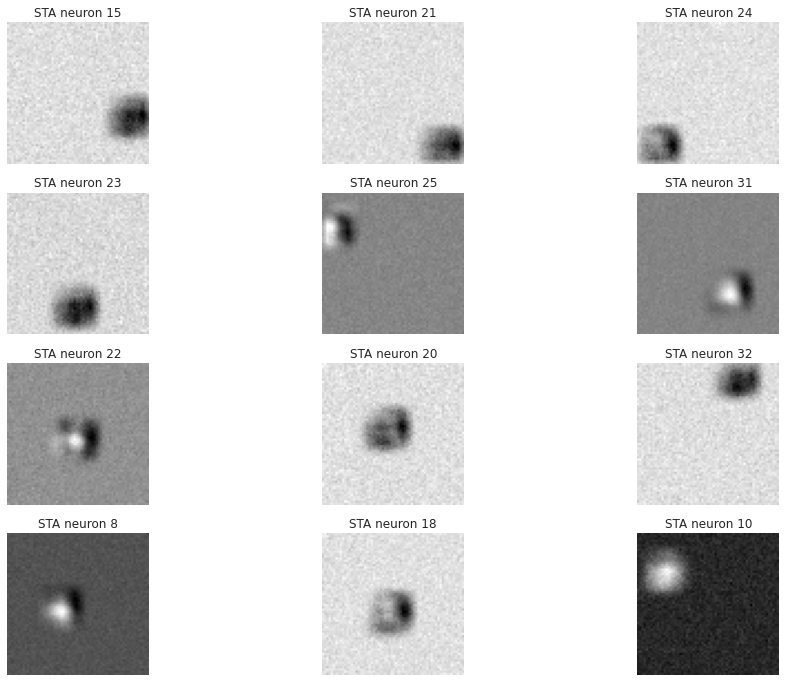

In [40]:
with torch.no_grad():
    sub_val_corrs = nlb.get_correlations(sub_model, sub_val_loader, device)
best_neurons_sub = np.argsort(-sub_val_corrs)
nlb.STA_model(sub_model, 'models/sub_model.pt', best_neurons_sub)

In [42]:
v1_model_or=nlb.configure_model(config, 13, device)
v1_train_loader_or, v1_val_loader_or, v1_test_loader_or = nlb.dataloader_from_mat(images_path, v1_responses_path, time_begin=125, time_end=200, batch_size=64)
tl.training_and_eval_with_lr(v1_model_or, config.get("epochs"), v1_train_loader_or, v1_test_loader_or, v1_val_loader_or, device, save_model=True, path_for_saving='models/v1_model_or.pt')

Epoch [1/50], validation correlation: 0.0132, trainloss: 0.1679
Epoch [2/50], validation correlation: 0.0504, trainloss: -0.3006
Epoch [3/50], validation correlation: 0.0669, trainloss: -0.6038
Epoch [4/50], validation correlation: 0.0665, trainloss: -0.2809
Epoch [5/50], validation correlation: 0.0918, trainloss: 0.1454
Epoch [6/50], validation correlation: 0.0529, trainloss: -0.4379
Epoch [7/50], validation correlation: 0.0694, trainloss: -1.1202
Epoch [8/50], validation correlation: 0.0460, trainloss: -0.5366
Epoch     9: reducing learning rate of group 0 to 1.0000e-02.
Epoch [9/50], validation correlation: 0.0911, trainloss: -0.7012
Epoch [10/50], validation correlation: 0.0893, trainloss: -0.5035
Early stopping triggered!

model saved asmodels/v1_model_or.pt
Test Loss: -0.2917
Test Correlation: 0.1161


The negative loss does not make any sense - it should be positive. Have not been able to find the bug yet. 

This is not great results:
1. Images shown only once, instead of 10 times per images in Sensorium -> More affected by noise.
2. Images are all natural -> Might have been useful to shows simpler images?

What can I do?
1. Different model? 
2. Pretrain? Has not worked well yet -> Have only pretrained core, and trained readout afterwards, but that might not be the best way?

In [34]:
next(iter(v1_train_loader))[0].shape
#fix bug

torch.Size([64, 1, 64, 64])